## Apply all imports here

In [2]:
from os import listdir, getcwd
import os
from os.path import isfile, join
import subprocess
import sys
import csv
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import ast
import re
import json
import statistics
import numpy as np


## Read all csv files 

In [6]:
mypath_soot = join(getcwd(), 'eval_results/soot_res')
mypath_sootup = join(getcwd(), 'eval_results/sootup_res')
# print(mypath)

csv_files_soot = [f for f in listdir(mypath_soot) if isfile(join(mypath_soot, f))]
csv_files_sootup = [f for f in listdir(mypath_sootup) if isfile(join(mypath_sootup, f))]
print(csv_files_soot)
print(csv_files_sootup)

csv_files_soot = ['soot_ide_eval_vm_merged.csv']
# csv_files_soot = ['convert_soot_commatosemicolon.csv']
csv_files_sootup = ['sootUp_ide_eval_mix_vm_1.csv']
# csv_files_soot = ['soot_ide_eval_mix_vm_individualbt.csv']
# csv_files_sootup = ['sootUp_ide_eval_mix_vm_individualbi.csv']

csv_files_sootup_nobi = ['sootUp_ide_eval_nobi.csv']


completepaths_soot = [os.path.join(mypath_soot, f) for f in csv_files_soot]
completepaths_sootup = [os.path.join(mypath_sootup, f) for f in csv_files_sootup]
completepaths_sootup_nobi = [os.path.join(mypath_sootup, f) for f in csv_files_sootup_nobi]
# print(completepaths)

desired_col_soot = ["jar","solver","thread","totalRuntime","cgConstructionTime","prop","method","mem","CallGraphAlgo","callGraphEdges","callGraphReachableNodes","initialStmtCount","stmtCountAfterApplyingBI","BodyTransformers","BodyTransformersMetrics"]
desired_col_sootup = ["jar","solver","thread","totalRuntime","cgConstructionTime","prop","method","mem","CallGraphAlgo","callGraphEdges","callGraphReachableNodes","initialStmtCount","stmtCountAfterApplyingBI","BodyInterceptors","BodyInterceptorsMetrics"]
# desired_col_sootup_nobi = ["jar","solver","thread","totalRuntime","cgConstructionTime","prop","method","mem","CallGraphAlgo","callGraphEdges","callGraphReachableNodes","initialStmtCount","stmtCountAfterApplyingBI"]

for completefilepath_soot in completepaths_soot:
    df_soot = pd.read_csv(completefilepath_soot, sep=";")

for completefilepath_sootup in completepaths_sootup:
    df_sootup = pd.read_csv(completefilepath_sootup, sep=";")

for completefilepath_sootup_nobi in completepaths_sootup_nobi:
    df_sootup_nobi = pd.read_csv(completefilepath_sootup_nobi, sep=";")

df_soot.columns = desired_col_soot
df_sootup.columns = desired_col_sootup
df_sootup_nobi.columns = desired_col_sootup

# Since when no body interceptors applied these colms doesn't have any value
df_sootup_nobi.drop(['BodyInterceptors', 'BodyInterceptorsMetrics'], axis=1, inplace=True)

def apply_complex_function1(x):
    return list(map(str.strip, x['BodyTransformers'].strip('[]').split(',')))

def apply_complex_function2(x):
    return list(map(str.strip, x['BodyInterceptors'].strip('[]').split(',')))

def convert_to_dict1(metric_str):
    metric_str['BodyTransformersMetrics'] = re.sub(r'(\b[\w.-]+\b)(?=\s*=\s*\[)', r'"\1"', metric_str['BodyTransformersMetrics'])  # Quote keys
    metric_str['BodyTransformersMetrics'] = metric_str['BodyTransformersMetrics'].replace('=', ':').replace('[', '[').replace(']', ']')
    return json.loads(metric_str['BodyTransformersMetrics'].replace("'", '"'))

def convert_to_dict2(metric_str):
    # Replace '=' with ':' and add double quotes around the keys
    metric_str['BodyInterceptorsMetrics'] = re.sub(r'@[\w]+', '', metric_str['BodyInterceptorsMetrics'])
    metric_str['BodyInterceptorsMetrics'] = re.sub(r'([\w\.]+)=', r'"\1":', metric_str['BodyInterceptorsMetrics'])
    metric_str['BodyInterceptorsMetrics'] = metric_str['BodyInterceptorsMetrics'].replace('=', ':').replace('[', '[').replace(']', ']')
    return json.loads(metric_str['BodyInterceptorsMetrics'].replace("'", '"'))

key_mapping = {
    'sootup.interceptors.TypeAssigner': 'jb.tr',
    'sootup.interceptors.DeadAssignmentEliminator': 'jb.dae',
    'sootup.interceptors.UnusedLocalEliminator': 'jb.ule',
    'sootup.interceptors.LocalSplitter': 'jb.ls',
    'sootup.interceptors.LocalPacker': 'jb.lp',
    'sootup.interceptors.CopyPropagator': 'jb.cp',
    'sootup.interceptors.Aggregator': 'jb.a',
    'sootup.interceptors.EmptySwitchEliminator': 'jb.ese',
    'sootup.interceptors.ConditionalBranchFolder': 'jb.cbf',
    'sootup.interceptors.NopEliminator': 'jb.ne',
    'sootup.interceptors.LocalNameStandardizer': 'jb.lns',
    'sootup.interceptors.UnreachableCodeEliminator': 'jb.uce'
}

def replace_keys_in_dict(original_dict):
    new_dict = {}
    for old_key, value in original_dict['BodyInterceptorsMetrics'].items():
        # Use the mapping to replace the key if it exists in the mapping
        new_key = key_mapping.get(old_key, old_key)  # If not in mapping, keep original key
        new_dict[new_key] = value
    return new_dict
    
df_soot['BodyTransformers'] = df_soot.apply(apply_complex_function1, axis=1)
df_sootup['BodyInterceptors'] = df_sootup.apply(apply_complex_function2, axis=1)
df_soot['BodyTransformersMetrics'] = df_soot.apply(convert_to_dict1, axis=1)
df_sootup['BodyInterceptorsMetrics'] = df_sootup.apply(convert_to_dict2, axis=1)

df_sootup['BodyInterceptorsMetrics'] = df_sootup.apply(replace_keys_in_dict, axis=1)


df_soot['stmtCountAfterApplyingBI'] = pd.to_numeric(df_soot['stmtCountAfterApplyingBI'], errors='coerce')
df_soot['initialStmtCount'] = pd.to_numeric(df_soot['initialStmtCount'], errors='coerce')
df_soot['totalRuntime'] = pd.to_numeric(df_soot['totalRuntime'], errors='coerce')
df_soot['cgConstructionTime'] = pd.to_numeric(df_soot['cgConstructionTime'], errors='coerce')
df_soot['prop'] = pd.to_numeric(df_soot['prop'], errors='coerce')
df_soot['method'] = pd.to_numeric(df_soot['method'], errors='coerce')
df_soot['mem'] = pd.to_numeric(df_soot['mem'], errors='coerce')
df_soot['callGraphEdges'] = pd.to_numeric(df_soot['callGraphEdges'], errors='coerce')
df_soot['callGraphReachableNodes'] = pd.to_numeric(df_soot['callGraphReachableNodes'], errors='coerce')


df_sootup['stmtCountAfterApplyingBI'] = pd.to_numeric(df_sootup['stmtCountAfterApplyingBI'], errors='coerce')
df_sootup['initialStmtCount'] = pd.to_numeric(df_sootup['initialStmtCount'], errors='coerce')
df_sootup['totalRuntime'] = pd.to_numeric(df_sootup['totalRuntime'], errors='coerce')
df_sootup['cgConstructionTime'] = pd.to_numeric(df_sootup['cgConstructionTime'], errors='coerce')
df_sootup['prop'] = pd.to_numeric(df_sootup['prop'], errors='coerce')
df_sootup['method'] = pd.to_numeric(df_sootup['method'], errors='coerce')
df_sootup['mem'] = pd.to_numeric(df_sootup['mem'], errors='coerce')
df_sootup['callGraphEdges'] = pd.to_numeric(df_sootup['callGraphEdges'], errors='coerce')
df_sootup['callGraphReachableNodes'] = pd.to_numeric(df_sootup['callGraphReachableNodes'], errors='coerce')


df_sootup_nobi['stmtCountAfterApplyingBI'] = pd.to_numeric(df_sootup_nobi['stmtCountAfterApplyingBI'], errors='coerce')
df_sootup_nobi['initialStmtCount'] = pd.to_numeric(df_sootup_nobi['initialStmtCount'], errors='coerce')
df_sootup_nobi['totalRuntime'] = pd.to_numeric(df_sootup_nobi['totalRuntime'], errors='coerce')
df_sootup_nobi['cgConstructionTime'] = pd.to_numeric(df_sootup_nobi['cgConstructionTime'], errors='coerce')
df_sootup_nobi['prop'] = pd.to_numeric(df_sootup_nobi['prop'], errors='coerce')
df_sootup_nobi['method'] = pd.to_numeric(df_sootup_nobi['method'], errors='coerce')
df_sootup_nobi['mem'] = pd.to_numeric(df_sootup_nobi['mem'], errors='coerce')
df_sootup_nobi['callGraphEdges'] = pd.to_numeric(df_sootup_nobi['callGraphEdges'], errors='coerce')
df_sootup_nobi['callGraphReachableNodes'] = pd.to_numeric(df_sootup_nobi['callGraphReachableNodes'], errors='coerce')


# Ensure that BodyTransformers column contains tuples
df_soot['BodyTransformers'] = df_soot['BodyTransformers'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_sootup['BodyInterceptors'] = df_sootup['BodyInterceptors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Function to sum the first value from each list in BodyInterceptorsMetrics
def calculate_bi_total_time(metrics):
    if isinstance(metrics, dict):  # Check if it's a dictionary
        total_time = sum(value[0] for key, value in metrics.items() if isinstance(value, list) and len(value) > 0)
        return total_time
    return 0  # Return 0 if BodyInterceptorsMetrics is not a dictionary or has no valid data

# Apply the function to create a new column 'BITotalTime'
df_soot['BITotalTime'] = df_soot['BodyTransformersMetrics'].apply(calculate_bi_total_time)
df_sootup['BITotalTime'] = df_sootup['BodyInterceptorsMetrics'].apply(calculate_bi_total_time)

# df_soot['BodyTransformers'][1]
# df_soot['BodyTransformersMetrics'][1].keys()
# df_sootup['BodyInterceptors'][1]
# df_sootup['BodyInterceptorsMetrics'][1].keys()


['convert_soot_commatosemicolon.csv', 'extra4jars.csv', 'soot_ide_eval_CHA_20_run1.csv', 'soot_ide_eval_CHA_20_run2_hp.csv', 'soot_ide_eval_mix_run3_hp.csv', 'soot_ide_eval_mix_vm_individualbt.csv', 'soot_ide_eval_RTA_17_run1.csv', 'soot_ide_eval_RTA_17_run2.csv', 'soot_ide_eval_vm_cha_1.csv', 'soot_ide_eval_vm_merged.csv', 'soot_ide_eval_vm_mix_1.csv', 'soot_ide_eval_vm_mix_2.csv', 'soot_ide_eval_vm_rta_1.csv']
['extra4jarssootup.csv', 'sootUp_ide_eval_CHA_13_run1_maxmethodsColUseless.csv', 'sootUp_ide_eval_mix_vm_1.csv', 'sootUp_ide_eval_mix_vm_individualbi.csv', 'sootUp_ide_eval_nobi.csv', 'sootUp_ide_eval_RTA_13_run1_maxmethodColUseless.csv']


In [19]:
df_soot.iloc[0:1]

,jar,solver,thread,totalRuntime,cgConstructionTime,prop,method,mem,CallGraphAlgo,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,BodyTransformers,BodyTransformersMetrics,BITotalTime
0,assertj-core-3.24.2,default,1,62110.0,6085.0,3020975.0,50.0,594.0,CHA,57910.0,13599.0,101912.0,102790.0,"(JB_LS, JB_TR, JB_LP)","{'jb.tr': [1424, 2], 'jb.lp': [697, -126], 'jb...",2852


In [58]:
df_sootup.iloc[0:1]

,jar,solver,thread,totalRuntime,cgConstructionTime,prop,method,mem,CallGraphAlgo,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,BodyInterceptors,BodyInterceptorsMetrics,BITotalTime
0,jackson-core-2.14.2,default,1,16050,231,200613,50,311,CHA,12965,2859,46237,46542,"(JB_LS, JB_TR, JB_LP)","{'jb.ls': [139, 106], 'jb.lp': [425, 120], 'jb...",1278


In [48]:
df_sootup_nobi.iloc[0:1]

,jar,solver,thread,totalRuntime,cgConstructionTime,prop,method,mem,CallGraphAlgo,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI
0,jsr305-3.0.2,default,1,4285,132,497,50,56,CHA,48,28,155,155


In [ ]:
for index, row in df_soot.loc[:, ['jar','method']].iterrows():
    if row['method'] < 5 and row['method'] > 0:
        print(row['jar'] + " " + str(row['method']))

## Grouped data

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


df_soot_analysis = pd.DataFrame({
    'jar': df_soot['jar'],
    'cgConstructionTime': df_soot['cgConstructionTime'],
    'CallGraphAlgo': df_soot['CallGraphAlgo'],
    'callGraphEdges': df_soot['callGraphEdges'],
    'callGraphReachableNodes': df_soot['callGraphReachableNodes'],
    'stmtDiff': df_soot['stmtCountAfterApplyingBI'] - df_soot['initialStmtCount'],
    'initialStmtCount': df_soot['initialStmtCount'],
    'stmtCountAfterApplyingBI': df_soot['stmtCountAfterApplyingBI'],
    'BITotalTime': df_soot['BITotalTime'],
    'BodyTransformers': df_soot['BodyTransformers'],
    'BodyTransformersMetrics': df_soot['BodyTransformersMetrics'],
    'totalRuntime': df_soot['totalRuntime'],
    'prop': df_soot['prop'],
    'mem': df_soot['mem']
})

df_sootup_analysis = pd.DataFrame({
    'jar': df_sootup['jar'],
    'cgConstructionTime': df_sootup['cgConstructionTime'],
    'CallGraphAlgo': df_sootup['CallGraphAlgo'],
    'callGraphEdges': df_sootup['callGraphEdges'],
    'callGraphReachableNodes': df_sootup['callGraphReachableNodes'],
    'stmtDiff': df_sootup['stmtCountAfterApplyingBI'] - df_sootup['initialStmtCount'],
    'initialStmtCount': df_sootup['initialStmtCount'],
    'stmtCountAfterApplyingBI': df_sootup['stmtCountAfterApplyingBI'],
    'BITotalTime': df_sootup['BITotalTime'],
    'BodyInterceptors': df_sootup['BodyInterceptors'],
    'BodyInterceptorsMetrics': df_sootup['BodyInterceptorsMetrics'],
    'totalRuntime': df_sootup['totalRuntime'],
    'prop': df_sootup['prop'],
    'mem': df_sootup['mem']
})

df_sootup_nobi_analysis = pd.DataFrame({
    'jar': df_sootup_nobi['jar'],
    'cgConstructionTime': df_sootup_nobi['cgConstructionTime'],
    'CallGraphAlgo': df_sootup_nobi['CallGraphAlgo'],
    'callGraphEdges': df_sootup_nobi['callGraphEdges'],
    'callGraphReachableNodes': df_sootup_nobi['callGraphReachableNodes'],
    'stmtDiff': df_sootup_nobi['stmtCountAfterApplyingBI'] - df_sootup['initialStmtCount'],
    'initialStmtCount': df_sootup_nobi['initialStmtCount'],
    'stmtCountAfterApplyingBI': df_sootup_nobi['stmtCountAfterApplyingBI'],
    'totalRuntime': df_sootup_nobi['totalRuntime'],
    'prop': df_sootup_nobi['prop'],
    'mem': df_sootup_nobi['mem']
})

df_soot_analysis = df_soot_analysis[df_soot_analysis['CallGraphAlgo'] == 'CHA']
df_sootup_analysis = df_sootup_analysis[df_sootup_analysis['CallGraphAlgo'] == 'CHA']
df_sootup_nobi_analysis = df_sootup_nobi_analysis[df_sootup_nobi_analysis['CallGraphAlgo'] == 'CHA']

# Function to aggregate the dictionaries with average of lists
def aggregate_dicts(dicts):
    aggregated = defaultdict(list)
    # Combine all the lists for each key
    for d in dicts:
        for key, values in d.items():
            if key in aggregated:
                aggregated[key] = [x + y for x, y in zip(aggregated[key], values)]
            else:
                aggregated[key] = values[:]
    # Take the average for each list
    for key, values in aggregated.items():
        count = len(dicts)
        aggregated[key] = [round(val / count, 2) for val in values]
    return dict(aggregated)

# Group by (jar, BodyInterceptors) and aggregate the values
grouped_df_soot = df_soot_analysis.groupby(['jar', 'BodyTransformers'], as_index=False).agg({
    'BodyTransformersMetrics': lambda x: aggregate_dicts(x),
    'cgConstructionTime': 'mean',  # Example: You can aggregate other columns like cgConstructionTime
    'callGraphEdges': 'mean',      # Example: Aggregate callGraphEdges by mean (or other function)
    'callGraphReachableNodes': 'mean',
    'initialStmtCount': 'mean',
    'stmtCountAfterApplyingBI': 'mean',
    'stmtDiff': 'mean',
    'totalRuntime': 'mean',
    'prop': 'mean',
    'mem': 'mean'
}).reset_index()


grouped_df_sootup = df_sootup_analysis.groupby(['jar', 'BodyInterceptors'], as_index=False).agg({
    'BodyInterceptorsMetrics': lambda x: aggregate_dicts(x),
    'cgConstructionTime': 'mean',  # Example: You can aggregate other columns like cgConstructionTime
    'callGraphEdges': 'mean',      # Example: Aggregate callGraphEdges by mean (or other function)
    'callGraphReachableNodes': 'mean',
    'initialStmtCount': 'mean',
    'stmtCountAfterApplyingBI': 'mean',
    'stmtDiff': 'mean',
    'totalRuntime': 'mean',
    'prop': 'mean',
    'mem': 'mean'
})

grouped_df_sootup_nobi = df_sootup_nobi_analysis.groupby(['jar'], as_index=False).agg({
    'cgConstructionTime': 'mean',  # Example: You can aggregate other columns like cgConstructionTime
    'callGraphEdges': 'mean',      # Example: Aggregate callGraphEdges by mean (or other function)
    'callGraphReachableNodes': 'mean',
    'initialStmtCount': 'mean',
    'stmtCountAfterApplyingBI': 'mean',
    'stmtDiff': 'mean',
    'totalRuntime': 'mean',
    'prop': 'mean',
    'mem': 'mean'
})

# Function to sum the first value from each list in BodyInterceptorsMetrics
def calculate_bi_total_time(metrics):
    if isinstance(metrics, dict):  # Check if it's a dictionary
        total_time = sum(value[0] for key, value in metrics.items() if isinstance(value, list) and len(value) > 0)
        return total_time
    return 0  # Return 0 if BodyInterceptorsMetrics is not a dictionary or has no valid data

# BI Total Time is for the grouped average now
# Apply the function to create a new column 'BITotalTime'
grouped_df_soot['BITotalTime'] = grouped_df_soot['BodyTransformersMetrics'].apply(calculate_bi_total_time)
grouped_df_sootup['BITotalTime'] = grouped_df_sootup['BodyInterceptorsMetrics'].apply(calculate_bi_total_time)


# Display the resulting DataFrame
# print(grouped_df_soot)
# print(grouped_df_sootup)


In [6]:
setofjarsinsoot = set()
# iterate through specific columns of the dataframe
for index, row in df_soot_analysis.loc[:, ['jar','BodyTransformers']].iterrows():
    setofjarsinsoot.add(tuple(row['jar']))
    # print(row['callGraphEdges'], row['BodyInterceptors'])

print(len(setofjarsinsoot))

setofjarsinsootup = set()
# iterate through specific columns of the dataframe
for index, row in df_sootup_analysis.loc[:, ['jar','BodyInterceptors']].iterrows():
    setofjarsinsootup.add(tuple(row['jar']))
    # print(row['callGraphEdges'], row['BodyInterceptors'])

print(len(setofjarsinsootup))

21
18


In [8]:
# df_soot_analysis.iloc[0:1]
grouped_df_soot.iloc[0:1]

,index,jar,BodyTransformers,BodyTransformersMetrics,cgConstructionTime,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,stmtDiff,totalRuntime,prop,mem,BITotalTime
0,0,commons-codec-1.15,"(JB_A, JB_CBF, JB_UCE, JB_ESE, JB_LP, JB_ULE, ...","{'jb.ule': [17.0, 1.0], 'jb.tr': [770.5, 0.0],...",2435.0,7210.0,1963.0,27946.0,20805.0,-7141.0,20908.0,569450.0,284.5,1945.5


In [11]:
# df_sootup_analysis.iloc[0:1]
grouped_df_sootup.iloc[11:14]

,jar,BodyInterceptors,BodyInterceptorsMetrics,cgConstructionTime,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,stmtDiff,totalRuntime,prop,mem,BITotalTime
11,commons-codec-1.15,"(JB_A, JB_CP, JB_CBF, JB_LS, JB_TR, JB_LP, JB_...","{'jb.cp': [369.0, 409.0], 'jb.ese': [1.0, 0.0]...",159.0,4437.0,1187.0,20198.0,20540.0,342.0,8304.0,31932.0,545.0,1651.0
12,commons-codec-1.15,"(JB_A, JB_CP, JB_ESE, JB_LP, JB_ULE, JB_LS, JB...","{'jb.lp': [377.0, 115.0], 'jb.tr': [855.0, -68...",281.0,4455.0,1187.0,20198.0,20606.0,408.0,15400.0,45919.0,477.0,2084.0
13,commons-codec-1.15,"(JB_A, JB_CP, JB_ESE, JB_LS, JB_TR, JB_LP, JB_...","{'jb.ese': [1.0, 0.0], 'jb.ule': [29.0, 5.0], ...",235.0,4455.0,1187.0,20198.0,20606.0,408.0,13958.0,33639.0,476.0,2187.0


In [34]:
grouped_df_sootup_nobi.iloc[0:1]

,jar,cgConstructionTime,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,stmtDiff,totalRuntime,prop,mem
0,commons-codec-1.15,553.954545,4378.272727,1187.0,20198.0,20198.0,6143.772727,10500.227273,127102.5,374.181818


## Correlation Matrix

In [71]:
# df = pd.DataFrame(df_soot_analysis)
# df = pd.DataFrame(grouped_df_sootup)


# # Convert 'BodyInterceptors' column into one-hot encoded (binary) columns
# # df_encoded = pd.get_dummies(df['BodyTransformers'].apply(lambda x: ','.join(x)))
# df_encoded = pd.get_dummies(df['BodyInterceptors'].apply(lambda x: ','.join(x)))


# # Combine the encoded columns with the original dataframe
# df_combined = pd.concat([df, df_encoded], axis=1)

# # Drop non-numeric columns (like 'jar' and 'type')
# # df_combined = df_combined.drop(['jar', 'BodyTransformers'], axis=1)
# df_combined = df_combined.drop(['jar', 'BodyInterceptors'], axis=1)


# # Select numerical columns for correlation
# numerical_cols = ['BITotalTime', 'cgConstructionTime', 'callGraphEdges', 'stmtDiff'] + list(df_encoded.columns)
# # Compute the correlation matrix
# correlation_matrix = df_combined[numerical_cols].corr()

# # Filter correlations to show only those >= 0.7 or <= -0.7
# filtered_corr_matrix = correlation_matrix.map(lambda x: x if abs(x) >= 0.6 else np.nan)

# # Plot the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=filtered_corr_matrix.isnull())
# # sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Filtered Correlation Heatmap (|corr| >= 0.6)')
# plt.show()

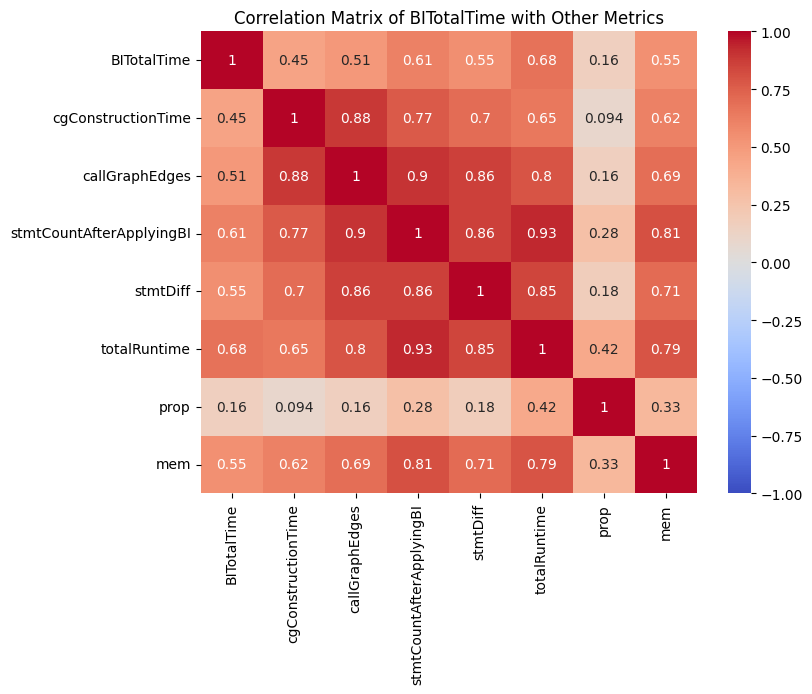

In [22]:
# Create DataFrame
# df = pd.DataFrame(grouped_df_soot)
df = pd.DataFrame(grouped_df_sootup)

# Select numerical columns for correlation
numerical_cols = ['BITotalTime', 'cgConstructionTime', 'callGraphEdges', 'stmtCountAfterApplyingBI', 'stmtDiff', 'totalRuntime', 'prop', 'mem']

# Compute the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Filter correlations to show only those >= 0.7 or <= -0.7
filtered_corr_matrix = corr_matrix.map(lambda x: x if abs(x) >= 0.6 else np.nan)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of BITotalTime with Other Metrics')
plt.show()


# ===================== RQ2 ==========================

## IF YOU WANT TO COMPARE INDIVIDUAL BODY INTERCEPTOR THEN RUN WITH JUST INDIVIDUAL INTERCEPTOR but (jb.ls, jb,tr) mandatory

### Average of all jars Runtime

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample Data
df_soot_allavg = pd.DataFrame({
    'BodyInterceptors': grouped_df_soot['BodyTransformers'],
    'BodyTransformersMetrics': grouped_df_soot['BodyTransformersMetrics']
})

df_sootup_allavg = pd.DataFrame({
    'BodyInterceptors': grouped_df_sootup['BodyInterceptors'],
    'BodyInterceptorsMetrics': grouped_df_sootup['BodyInterceptorsMetrics']
})

# Add a 'type' column to differentiate between soot and sootup
df_soot_allavg['type'] = 'soot'
df_sootup_allavg['type'] = 'sootup'

# Combine both DataFrames
df_combined_avg = pd.concat([df_soot_allavg, df_sootup_allavg])

# Create DataFrame
df = pd.DataFrame(df_combined_avg)


## Individual Jars wrt cgConstructionTime, callGraphEdges, callGraphReachableNodes, stmtDiff, totalRuntime, mem, prop

#### cgConstructionTime

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_cgConstructionTime'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher cgConstructionTime than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='cgConstructionTime').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher cgConstructionTime than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('cgConstructionTime', fontsize=12)
    ax.set_title(f'cgConstructionTime for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher cgConstructionTime than sootup
print(f"Number of jars where soot has a higher cgConstructionTime than sootup: {soot_higher_count}")

Number of jars where soot has a higher cgConstructionTime than sootup: 21


#### callGraphEdges

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_callGraphEdges'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher callGraphEdges than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='callGraphEdges').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher callGraphEdges than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('callGraphEdges', fontsize=12)
    ax.set_title(f'callGraphEdges for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher callGraphEdges than sootup
print(f"Number of jars where soot has a higher callGraphEdges than sootup: {soot_higher_count}")

Number of jars where soot has a higher callGraphEdges than sootup: 21


#### callGraphReachableNodes

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_callGraphReachableNodes'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher callGraphReachableNodes than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='callGraphReachableNodes').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher callGraphReachableNodes than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('callGraphReachableNodes', fontsize=12)
    ax.set_title(f'callGraphReachableNodes for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher callGraphReachableNodes than sootup
print(f"Number of jars where soot has a higher callGraphReachableNodes than sootup: {soot_higher_count}")

Number of jars where soot has a higher callGraphReachableNodes than sootup: 21


#### stmtDiff

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_stmtDiff'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher stmtDiff than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='stmtDiff').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher stmtDiff than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('stmtDiff', fontsize=12)
    ax.set_title(f'stmtDiff for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher stmtDiff than sootup
print(f"Number of jars where soot has a higher stmtDiff than sootup: {soot_higher_count}")

Number of jars where soot has a higher stmtDiff than sootup: 1


#### totalRuntime

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_totalRuntime'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher totalRuntime than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='totalRuntime').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher totalRuntime than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('totalRuntime', fontsize=12)
    ax.set_title(f'totalRuntime for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher totalRuntime than sootup
print(f"Number of jars where soot has a higher totalRuntime than sootup: {soot_higher_count}")

Number of jars where soot has a higher totalRuntime than sootup: 19


#### mem

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_mem'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher mem than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='mem').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher mem than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('totalmemory', fontsize=12)
    ax.set_title(f'totalmemory for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher mem than sootup
print(f"Number of jars where soot has a higher totalmem than sootup: {soot_higher_count}")

Number of jars where soot has a higher totalmem than sootup: 15


#### prop

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_prop'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher prop than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='prop').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher prop than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('propagations', fontsize=12)
    ax.set_title(f'propagations for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher prop than sootup
print(f"Number of jars where soot has a higher prop than sootup: {soot_higher_count}")

Number of jars where soot has a higher prop than sootup: 17


#### initialStmtCount

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_initialStmtCount'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher prop than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='initialStmtCount').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher prop than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('initialStmtCount', fontsize=12)
    ax.set_title(f'initialStmtCount for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher prop than sootup
print(f"Number of jars where soot has a higher initialStmtCount than sootup: {soot_higher_count}")

Number of jars where soot has a higher initialStmtCount than sootup: 21


# ===================== RQ3 ==========================

### Stacked Column Chart for Body Interceptors Time and Total Time

C:\Users\sahil\AppData\Local\Temp\ipykernel_22724\4205978542.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(data_soot_grp_filtered['BodyTransformers_str'], rotation=45, ha='right')
C:\Users\sahil\AppData\Local\Temp\ipykernel_22724\4205978542.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(data_sootup_grp_filtered['BodyInterceptors_str'], rotation=45, ha='right')


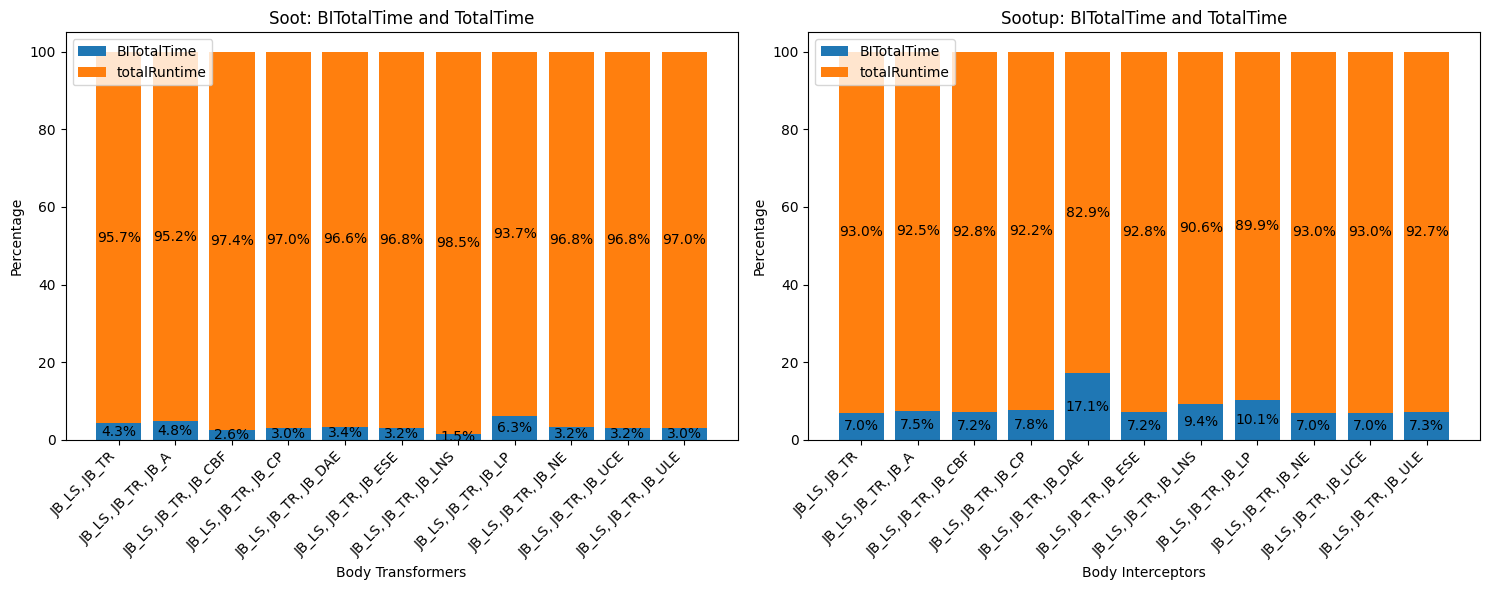

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
df_s = {
    'BodyTransformers': grouped_df_soot['BodyTransformers'],
    'BITotalTime': grouped_df_soot['BITotalTime'],
    'totalRuntime': grouped_df_soot['totalRuntime']
}

df_sup = {
    'BodyInterceptors': grouped_df_sootup['BodyInterceptors'],
    'BITotalTime': grouped_df_sootup['BITotalTime'],
    'totalRuntime': grouped_df_sootup['totalRuntime']
}

# Create DataFrame
df_s = pd.DataFrame(df_s)
df_sup = pd.DataFrame(df_sup)

data_soot_grp = df_s.groupby(['BodyTransformers'], as_index=False).agg({
    'BITotalTime': 'mean',
    'totalRuntime': 'mean'
})

data_sootup_grp = df_sup.groupby(['BodyInterceptors'], as_index=False).agg({
    'BITotalTime': 'mean',
    'totalRuntime': 'mean'
})

# Convert the 'BodyInterceptors' tuple values into string for plotting
data_soot_grp['BodyTransformers_str'] = data_soot_grp['BodyTransformers'].apply(lambda x: ', '.join(x))
data_sootup_grp['BodyInterceptors_str'] = data_sootup_grp['BodyInterceptors'].apply(lambda x: ', '.join(x))

# Calculate the total time for each row to normalize the values
data_soot_grp['Total'] = data_soot_grp['BITotalTime'] + data_soot_grp['totalRuntime']
data_sootup_grp['Total'] = data_sootup_grp['BITotalTime'] + data_sootup_grp['totalRuntime']

# Normalize the values to get the percentage
data_soot_grp['BITotalTime_perc'] = (data_soot_grp['BITotalTime'] / data_soot_grp['Total']) * 100
data_soot_grp['totalRuntime_perc'] = (data_soot_grp['totalRuntime'] / data_soot_grp['Total']) * 100
data_sootup_grp['BITotalTime_perc'] = (data_sootup_grp['BITotalTime'] / data_sootup_grp['Total']) * 100
data_sootup_grp['totalRuntime_perc'] = (data_sootup_grp['totalRuntime'] / data_sootup_grp['Total']) * 100


# # Create Stacked Column Chart
# plt.figure(figsize=(10, 6))
# # data_soot_grp.set_index('BodyTransformers').plot(kind='bar', stacked=True)
# data_sootup_grp.set_index('BodyInterceptors').plot(kind='bar', stacked=True)

# # Add labels and title
# plt.xlabel('Body Interceptors')
# plt.ylabel('Time (in seconds)')
# plt.title('Stacked Column Chart: BITotalTime and TotalTime')
# plt.legend(['BITotalTime', 'TotalTime'])
# plt.xticks(rotation=45, ha='right')

# # Show plot
# plt.tight_layout()
# plt.show()

# Create subplots: one for soot and one for sootup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


# # Filter out the rows where BITotalTime_perc is greater than x%
# data_soot_grp_filtered = data_soot_grp[data_soot_grp['BITotalTime_perc'] > 10.5]
# data_sootup_grp_filtered = data_sootup_grp[data_sootup_grp['BITotalTime_perc'] > 22.3]

data_soot_grp_filtered = data_soot_grp
data_sootup_grp_filtered = data_sootup_grp

# Plot BITotalTime and TotalTime stacked for soot
bars1 = ax1.bar(data_soot_grp_filtered['BodyTransformers_str'], data_soot_grp_filtered['BITotalTime_perc'], label='BITotalTime')
bars2 = ax1.bar(data_soot_grp_filtered['BodyTransformers_str'], data_soot_grp_filtered['totalRuntime_perc'], 
                bottom=data_soot_grp_filtered['BITotalTime_perc'], label='totalRuntime')

# Annotate the bars for soot
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                     xytext=(0, 0), 
                     textcoords="offset points",
                     ha='center', va='center', fontsize=10, color='black')

# Plot BITotalTime and TotalTime stacked for sootup
bars3 = ax2.bar(data_sootup_grp_filtered['BodyInterceptors_str'], data_sootup_grp_filtered['BITotalTime_perc'], label='BITotalTime')
bars4 = ax2.bar(data_sootup_grp_filtered['BodyInterceptors_str'], data_sootup_grp_filtered['totalRuntime_perc'], 
                bottom=data_sootup_grp_filtered['BITotalTime_perc'], label='totalRuntime')

# Annotate the bars for sootup
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.1f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                     xytext=(0, 0), 
                     textcoords="offset points",
                     ha='center', va='center', fontsize=10, color='black')

# Add labels, titles, and legends
ax1.set_xlabel('Body Transformers')
ax1.set_ylabel('Percentage')
ax1.set_title('Soot: BITotalTime and TotalTime')
ax1.legend(loc='upper left')
ax1.set_xticklabels(data_soot_grp_filtered['BodyTransformers_str'], rotation=45, ha='right')

ax2.set_xlabel('Body Interceptors')
ax2.set_ylabel('Percentage')
ax2.set_title('Sootup: BITotalTime and TotalTime')
ax2.legend(loc='upper left')
ax2.set_xticklabels(data_sootup_grp_filtered['BodyInterceptors_str'], rotation=45, ha='right')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Compare SootUp BI Vs No BI

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individualjar_totalRuntime_nobi_compare'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist


# Sample Data for grouped_df_sootup (for demonstration, based on your description)
data_sootup_payoff = {
    'jar': grouped_df_sootup['jar'],
    'BodyInterceptors': grouped_df_sootup['BodyInterceptors'],
    'BITotalTime': grouped_df_sootup['BITotalTime'],
    'totalRuntime': grouped_df_sootup['totalRuntime']
}

# Sample Data for grouped_df_sootup_nobi (benchmark values)
data_sootup_nobi_payoff = {
    'jar': grouped_df_sootup_nobi['jar'],
    'totalRuntime': grouped_df_sootup_nobi['totalRuntime']  # This is the benchmark runtime without interceptors
}

# Create DataFrames
data_sootup_payoff = pd.DataFrame(data_sootup_payoff)
data_sootup_nobi_payoff = pd.DataFrame(data_sootup_nobi_payoff)

# Convert BodyInterceptors tuples to strings for easier plotting
data_sootup_payoff['BodyInterceptors_str'] = data_sootup_payoff['BodyInterceptors'].apply(lambda x: ', '.join(x))

# Merge the benchmark data with the main DataFrame
# This will give NaN for jars that don't exist in the benchmark DataFrame
df_merged = pd.merge(data_sootup_payoff, data_sootup_nobi_payoff, on='jar', how='left', suffixes=('_with_interceptors', '_benchmark'))

# Get unique jars
unique_jars = df_merged['jar'].unique()

# Create bar chart for each jar
for jar in unique_jars:
    # Filter data for the current jar
    jar_data = df_merged[df_merged['jar'] == jar]
    
    # Get the benchmark value (if exists)
    benchmark_runtime = jar_data['totalRuntime_benchmark'].values[0] if pd.notna(jar_data['totalRuntime_benchmark'].values[0]) else None

    # Compute the remaining runtime (totalRuntime - BITotalTime)
    jar_data['remainingRuntime'] = jar_data['totalRuntime_with_interceptors'] - jar_data['BITotalTime']

    # Plot the bar chart
    fig = plt.figure(figsize=(10, 6))
    
    # Plot BITotalTime (orange) and stack the remaining runtime (blue) on top
    bars1 = plt.bar(jar_data['BodyInterceptors_str'], jar_data['BITotalTime'], color='orange', label='BITotalTime')
    bars2 = plt.bar(jar_data['BodyInterceptors_str'], jar_data['remainingRuntime'], bottom=jar_data['BITotalTime'], color='skyblue', label='Remaining Runtime')

    # Add labels above the bars
    for bars, label_name in zip([bars1, bars2], ['BITotalTime', 'TotalRuntime']):
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
                bar.get_y() + height,  # y-coordinate (top of the bar)
                f'{height:.1f}',  # The label (formatted as a number with 1 decimal place)
                ha='center',  # Horizontal alignment
                va='bottom',  # Vertical alignment
                fontsize=10  # Font size
            )

    # Add labels and title
    plt.xlabel('Body Interceptors')
    plt.ylabel('Total Runtime (seconds)')
    plt.title(f'Total Runtime for {jar}')

    # Plot the benchmark line if it exists
    if benchmark_runtime is not None:
        plt.axhline(y=benchmark_runtime, color='red', linestyle='--', label=f'Benchmark (No Interceptors) = {benchmark_runtime} seconds')
    
    # Add the legend if the benchmark line is plotted
    if benchmark_runtime is not None:
        plt.legend()

    # Rotate x-axis labels for clarity
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_payoff_inone.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)


C:\Users\sahil\AppData\Local\Temp\ipykernel_46372\1754159205.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jar_data['remainingRuntime'] = jar_data['totalRuntime_with_interceptors'] - jar_data['BITotalTime']
C:\Users\sahil\AppData\Local\Temp\ipykernel_46372\1754159205.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jar_data['remainingRuntime'] = jar_data['totalRuntime_with_interceptors'] - jar_data['BITotalTime']
C:\Users\sahil\AppData\Local\Temp\ipykernel_46372\1754159205.py:47: SettingWithCopyW

### Top 10 BI Comparison

In [65]:
data_soot_top10 = {
    'jar': grouped_df_soot['jar'],
    'BodyInterceptors': grouped_df_soot['BodyTransformers'],
    'totalRuntime': grouped_df_soot['totalRuntime']
}

data_sootup_top10 = {
    'jar': grouped_df_sootup['jar'],
    'BodyInterceptors': grouped_df_sootup['BodyInterceptors'],
    'totalRuntime': grouped_df_sootup['totalRuntime']
}

df = pd.DataFrame(data_sootup_top10)

# Step 1: Sort the data by `totalRuntime` for each jar and take the top 10
top_bi_per_jar = df.groupby('jar').apply(lambda x: x.nsmallest(110, 'totalRuntime')).reset_index(drop=True)

# Step 2: Create a dictionary to store the top BodyInterceptors for each jar
top_bi_dict = {}
for jar in top_bi_per_jar['jar'].unique():
    top_bi_dict[jar] = set(top_bi_per_jar[top_bi_per_jar['jar'] == jar]['BodyInterceptors'])
    
# Step 3: Calculate the threshold for 80% of the jars
total_jars = len(top_bi_dict)
threshold_jars_percent = int(0.7 * total_jars)

# Step 4: Count the occurrences of each BodyInterceptors sequence in the top 10 across jars
from collections import Counter

# Flatten all the top 10 sequences into a list
all_top_bi_sequences = [interceptor for interceptors in top_bi_dict.values() for interceptor in interceptors]

# Count how often each sequence appears across jars
sequence_counts = Counter(all_top_bi_sequences)

# Step 5: Filter out the sequences that appear in at least 80% of the jars
common_sequences = [sequence for sequence, count in sequence_counts.items() if count >= threshold_jars_percent]

print("Common sequences appearing in __ % or more jars:")
print(common_sequences)


############ Bottom ##############
bottom_bi_per_jar = df.groupby('jar').apply(lambda x: x.nlargest(20, 'totalRuntime')).reset_index(drop=True)

bottom_bi_dict = {}
for jar in bottom_bi_per_jar['jar'].unique():
    bottom_bi_dict[jar] = set(bottom_bi_per_jar[bottom_bi_per_jar['jar'] == jar]['BodyInterceptors'])
    
total_jars = len(bottom_bi_dict)
threshold_jars_percent = int(0.5 * total_jars)

all_bottom_bi_sequences = [interceptor for interceptors in bottom_bi_dict.values() for interceptor in interceptors]

sequence_counts = Counter(all_bottom_bi_sequences)

common_sequences = [sequence for sequence, count in sequence_counts.items() if count >= threshold_jars_percent]

print("Common sequences appearing in __ % or more jars:")
print(common_sequences)


# SOOT
# top 80 sequences jars 0.7 [('JB_LS', 'JB_TR', 'JB_CP', 'JB_DAE', 'JB_CBF', 'JB_UCE', 'JB_A', 'JB_LP', 'JB_ULE', 'JB_ESE'), 
#                            ('JB_A', 'JB_LS', 'JB_TR', 'JB_ESE', 'JB_LP', 'JB_ULE', 'JB_CP', 'JB_DAE', 'JB_CBF', 'JB_UCE')]

# top 30 sequences jars 0.5 [('JB_ESE', 'JB_LS', 'JB_TR', 'JB_A', 'JB_CP', 'JB_DAE', 'JB_CBF', 'JB_UCE', 'JB_LP', 'JB_ULE')]

# bottom 40 sequences jars 0.7 [('JB_LP', 'JB_ULE', 'JB_ESE', 'JB_CP', 'JB_A', 'JB_LS', 'JB_TR')]
# bottom 20 sequences jars 0.5 [('JB_LP', 'JB_ULE', 'JB_ESE', 'JB_CP', 'JB_A', 'JB_LS', 'JB_TR'), 
#                               ('JB_LP', 'JB_ULE', 'JB_CP', 'JB_A', 'JB_LS', 'JB_TR', 'JB_ESE'), 
#                               ('JB_LP', 'JB_ULE', 'JB_LS', 'JB_TR', 'JB_ESE', 'JB_CP', 'JB_A')]


# SOOTUP
# top 110 sequences jars 0.7 [('JB_ESE', 'JB_LS', 'JB_TR', 'JB_LP', 'JB_ULE', 'JB_A', 'JB_CP', 'JB_CBF')]

# top 70 sequences jars 0.5 [('JB_LS', 'JB_TR', 'JB_ESE', 'JB_LP', 'JB_ULE', 'JB_CP', 'JB_CBF', 'JB_A'), 
#                            ('JB_ESE', 'JB_LS', 'JB_TR', 'JB_LP', 'JB_ULE', 'JB_A', 'JB_CP', 'JB_CBF')]

# bottom 40 sequences jars 0.7 [('JB_LS', 'JB_TR', 'JB_LP', 'JB_ULE', 'JB_CP', 'JB_ESE', 'JB_A')]
# bottom 60 sequences jars 0.7 [('JB_LS', 'JB_TR', 'JB_LP', 'JB_ULE', 'JB_CP', 'JB_ESE', 'JB_A'), 
#                               ('JB_LP', 'JB_ULE', 'JB_CP', 'JB_LS', 'JB_TR', 'JB_A', 'JB_ESE')]

# bottom 20 sequences jars 0.6 [('JB_LS', 'JB_TR', 'JB_LP', 'JB_ULE', 'JB_CP', 'JB_ESE', 'JB_A')]

Common sequences appearing in __ % or more jars:
[('JB_ESE', 'JB_LS', 'JB_TR', 'JB_LP', 'JB_ULE', 'JB_A', 'JB_CP', 'JB_CBF')]
Common sequences appearing in __ % or more jars:
[('JB_LS', 'JB_TR', 'JB_LP', 'JB_ULE', 'JB_CP', 'JB_ESE', 'JB_A')]


C:\Users\sahil\AppData\Local\Temp\ipykernel_46372\2741434941.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_bi_per_jar = df.groupby('jar').apply(lambda x: x.nsmallest(110, 'totalRuntime')).reset_index(drop=True)
C:\Users\sahil\AppData\Local\Temp\ipykernel_46372\2741434941.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bottom_bi_per_jar = df.groupby('jar').apply(lambda x: x.nlargest(20, 'tota

#### Soot

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individualjar_totalRuntime_top_bottom_soot'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Sample data
data_top_bottom_soot = {
    'jar': grouped_df_soot['jar'],
    'BodyInterceptors': grouped_df_soot['BodyTransformers'],
    'BITotalTime': grouped_df_soot['BITotalTime'],
    'totalRuntime': grouped_df_soot['totalRuntime']
}

# Specify the BodyInterceptors tuples to plot
specified_interceptors = [
    ('JB_LS', 'JB_TR', 'JB_CP', 'JB_DAE', 'JB_CBF', 'JB_UCE', 'JB_A', 'JB_LP', 'JB_ULE', 'JB_ESE'),
    ('JB_A', 'JB_LS', 'JB_TR', 'JB_ESE', 'JB_LP', 'JB_ULE', 'JB_CP', 'JB_DAE', 'JB_CBF', 'JB_UCE'),
    ('JB_ESE', 'JB_LS', 'JB_TR', 'JB_A', 'JB_CP', 'JB_DAE', 'JB_CBF', 'JB_UCE', 'JB_LP', 'JB_ULE'),
    # Bottom
    ('JB_LP', 'JB_ULE', 'JB_ESE', 'JB_CP', 'JB_A', 'JB_LS', 'JB_TR'),
    ('JB_LP', 'JB_ULE', 'JB_CP', 'JB_A', 'JB_LS', 'JB_TR', 'JB_ESE'), 
    ('JB_LP', 'JB_ULE', 'JB_LS', 'JB_TR', 'JB_ESE', 'JB_CP', 'JB_A')
]

# Convert the data to a DataFrame
df = pd.DataFrame(data_top_bottom_soot)

# Convert the 'BodyInterceptors' tuple to string for easier plotting
df['BodyInterceptors_str'] = df['BodyInterceptors'].apply(lambda x: ', '.join(x))

# Filter only the specified BodyInterceptors tuples
df_filtered = df[df['BodyInterceptors'].apply(lambda x: x in specified_interceptors)]

# Create the horizontal bar chart for each jar
for jar in df_filtered['jar'].unique():
    # Filter data for the current jar
    jar_data = df_filtered[df_filtered['jar'] == jar]

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate the remainder of the total runtime (i.e., totalRuntime - BITotalTime)
    runtime_remainder = jar_data['totalRuntime'] - jar_data['BITotalTime']

    # Plot the stacked horizontal bar (BITotalTime in orange, remainder in skyblue)
    bars1 = ax.barh(jar_data['BodyInterceptors_str'], jar_data['BITotalTime'], color='orange', label='BITotalTime')
    bars2 = ax.barh(jar_data['BodyInterceptors_str'], runtime_remainder, left=jar_data['BITotalTime'], color='skyblue', label='Remainder of totalRuntime')

    # Annotate BITotalTime on the bars
    for bar in bars1:
        width = bar.get_width()
        ax.annotate(f'{width:.1f}',  # Text of the annotation
                    xy=(width, bar.get_y() + bar.get_height() / 2),  # x, y of annotation
                    xytext=(5, 0),  # Offset to prevent text from being too close to the bar
                    textcoords="offset points",
                    ha='left', va='center', color='black')

    # Annotate totalRuntime (BITotalTime + remainder) on the bars
    for bar in bars2:
        total = bar.get_width() + bar.get_x()  # totalRuntime is width of second bar plus its starting point
        ax.annotate(f'{total:.1f}',  # Text of the annotation
                    xy=(total, bar.get_y() + bar.get_height() / 2),  # x, y of annotation
                    xytext=(5, 0),  # Offset to prevent text from being too close to the bar
                    textcoords="offset points",
                    ha='left', va='center', color='black')

    # Add labels and title
    ax.set_xlabel('Time (seconds)')
    ax.set_title(f'Total Runtime and BITotalTime for {jar}')
    ax.legend()

    # Show plot with tight layout
    plt.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_top_bottom_soot.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

#### SootUp

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individualjar_totalRuntime_top_bottom_sootup'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Sample data
data_top_bottom_sootup = {
    'jar': grouped_df_sootup['jar'],
    'BodyInterceptors': grouped_df_sootup['BodyInterceptors'],
    'BITotalTime': grouped_df_sootup['BITotalTime'],
    'totalRuntime': grouped_df_sootup['totalRuntime']
}

# Specify the BodyInterceptors tuples to plot
specified_interceptors = [
    ('JB_ESE', 'JB_LS', 'JB_TR', 'JB_LP', 'JB_ULE', 'JB_A', 'JB_CP', 'JB_CBF'),
    ('JB_LS', 'JB_TR', 'JB_ESE', 'JB_LP', 'JB_ULE', 'JB_CP', 'JB_CBF', 'JB_A'),
    # Bottom
    ('JB_LS', 'JB_TR', 'JB_LP', 'JB_ULE', 'JB_CP', 'JB_ESE', 'JB_A'),
    ('JB_LP', 'JB_ULE', 'JB_CP', 'JB_LS', 'JB_TR', 'JB_A', 'JB_ESE')
]

# Convert the data to a DataFrame
df = pd.DataFrame(data_top_bottom_sootup)

# Convert the 'BodyInterceptors' tuple to string for easier plotting
df['BodyInterceptors_str'] = df['BodyInterceptors'].apply(lambda x: ', '.join(x))

# Filter only the specified BodyInterceptors tuples
df_filtered = df[df['BodyInterceptors'].apply(lambda x: x in specified_interceptors)]

# Create the horizontal bar chart for each jar
for jar in df_filtered['jar'].unique():
    # Filter data for the current jar
    jar_data = df_filtered[df_filtered['jar'] == jar]

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate the remainder of the total runtime (i.e., totalRuntime - BITotalTime)
    runtime_remainder = jar_data['totalRuntime'] - jar_data['BITotalTime']

    # Plot the stacked horizontal bar (BITotalTime in orange, remainder in skyblue)
    bars1 = ax.barh(jar_data['BodyInterceptors_str'], jar_data['BITotalTime'], color='orange', label='BITotalTime')
    bars2 = ax.barh(jar_data['BodyInterceptors_str'], runtime_remainder, left=jar_data['BITotalTime'], color='skyblue', label='Remainder of totalRuntime')

    # Annotate BITotalTime on the bars
    for bar in bars1:
        width = bar.get_width()
        ax.annotate(f'{width:.1f}',  # Text of the annotation
                    xy=(width, bar.get_y() + bar.get_height() / 2),  # x, y of annotation
                    xytext=(5, 0),  # Offset to prevent text from being too close to the bar
                    textcoords="offset points",
                    ha='left', va='center', color='black')

    # Annotate totalRuntime (BITotalTime + remainder) on the bars
    for bar in bars2:
        total = bar.get_width() + bar.get_x()  # totalRuntime is width of second bar plus its starting point
        ax.annotate(f'{total:.1f}',  # Text of the annotation
                    xy=(total, bar.get_y() + bar.get_height() / 2),  # x, y of annotation
                    xytext=(5, 0),  # Offset to prevent text from being too close to the bar
                    textcoords="offset points",
                    ha='left', va='center', color='black')

    # Add labels and title
    ax.set_xlabel('Time (seconds)')
    ax.set_title(f'Total Runtime and BITotalTime for {jar}')
    ax.legend()

    # Show plot with tight layout
    plt.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_top_bottom_sootup.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)